In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt


Dataset Preparation

In [4]:
# Set Hyperparameters
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 16
torch.manual_seed(random_seed)

In [6]:
# Load Training and Test Data
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train = True, download = True,
                            transform = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                (0.137,), (0.381,)) # mean, std. deviation of the MNIST dataset
                            ])),
  batch_size = batch_size_train, shuffle = True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                (0.137,), (0.381,)) # mean, std. deviation of the MNIST dataset
                             ])),
  batch_size=batch_size_test, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:04, 2370525.97it/s]                            


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142009.38it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2331350.92it/s]                            
0it [00:00, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 53333.76it/s]            


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape, example_targets.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

Building the Neural Network

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [0]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]

In [0]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [0]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.277633
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.326963
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.299730
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.317150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.315114
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.278075
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.285118
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.253969
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.250991
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.225069
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.208197
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.155281
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.143101
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.132745
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.977930
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.021571
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.842552
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.840292
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.729491
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.741081
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2124, Accuracy: 9376/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.504227
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.447125
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.404364
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.431306
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.487734
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.448369
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.503666
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.581038
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.404195
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.519927
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.428121
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.419950
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.440673
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.390289
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.635849
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.357331
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.713495
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.437795
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.598799
Train Epoch: 2 [12160

In [14]:
len(test_counter), len(test_losses)

(10, 10)

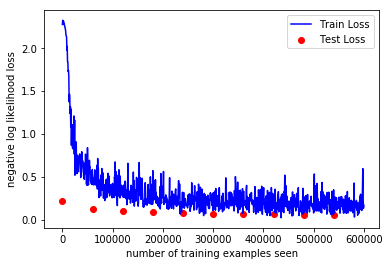

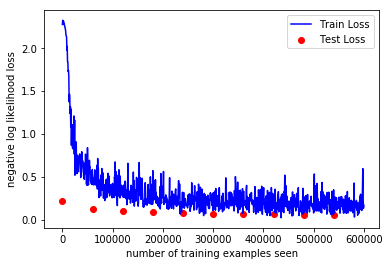

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig